In [1]:
import keras
import numpy as np
import csv
from matplotlib import pyplot as plt
from keras.models import Model
from keras.models import Sequential
from keras import layers
from keras.layers import *
from keras.layers import Dense, LSTM
from keras.optimizers import RMSprop
from keras import activations
from keras import backend as K
from keras import optimizers

Using TensorFlow backend.


In [2]:
# -*- -*- -*- -*- -*- -*- #

V1 = np.load('C:/Users/richa/Desktop/Heart/np/H1.npy')

### Normalization

def normal(data):
    
    data_mean = data.mean()
    data_std = data.std()
    
    data = data - data_mean
    data = data / data_std
    
    return data

V1_n = normal(V1)

### Generate data

len_input = 500
len_predic = 90
input_dim = 3
predic_dim = 3
devide_train_test = 0.7

n_s1 = V1_n.shape[1] - (len_input + len_predic) + 1
print("The length of data is %d" %(V1_n.shape[1]))
print("The number of samples is %d" %(n_s1))

V1_train = int(n_s1*devide_train_test)
V1_test = n_s1 - V1_train
print("The number of train samples is %d" %(V1_train))
print("The number of test samples is %d" %(V1_test))

# Invivo-I
num_id1 = np.arange(V1_train)
num_id2 = np.arange(V1_test)
np.random.shuffle(num_id1)
np.random.shuffle(num_id2)

for i in range(n_s1):
    Input_data = V1_n[:input_dim, i : i + len_input]
    Predict_data = V1_n[:input_dim, i + len_input : i + len_input + len_predic]
    if i < V1_train:
        np.save("C:/Users/richa/Desktop/Heart/net/" + "Invivo-I/" + "train_input/" + str(num_id1[i]) + "_train_input.npy", Input_data)
        np.save("C:/Users/richa/Desktop/Heart/net/" + "Invivo-I/" + "train_predict/" + str(num_id1[i]) + "_train_predict.npy", Predict_data)
    else:
        np.save("C:/Users/richa/Desktop/Heart/net/" + "Invivo-I/" + "test_input/" + str(num_id2[i - V1_train]) + "_test_input.npy", Input_data)
        np.save("C:/Users/richa/Desktop/Heart/net/" + "Invivo-I/" + "test_predict/" + str(num_id2[i - V1_train]) + "_test_predict.npy", Predict_data)
print('Invivo-I finished')


The length of data is 750
The number of samples is 161
The number of train samples is 112
The number of test samples is 49
Invivo-I finished


In [3]:
batch_size = 10
n_train = int(V1_train/batch_size)*batch_size
n_test = int(V1_test/batch_size)*batch_size

### Generate train_data

def generate_train_data():
    
    inputs = np.zeros((batch_size, len_input, input_dim), dtype = np.float32)
    predics = np.zeros((batch_size, len_predic * predic_dim), dtype = np.float32)

    get_batch = 0
    
    while 1:
        for id in range(n_train):
            
            inputs[get_batch,:,:] = np.load("C:/Users/richa/Desktop/Heart/net/" + "Invivo-I/" + "train_input/" + str(id) + "_train_input.npy").T
            predict_temp = np.load("C:/Users/richa/Desktop/Heart/net/" + "Invivo-I/" + "train_predict/" + str(id) + "_train_predict.npy")
            predics[get_batch,:] = predict_temp.reshape(1, len_predic * predic_dim)
            
            get_batch += 1
            
            if get_batch >= batch_size:
                
                yield inputs, predics
                
                get_batch = 0
                
                inputs = np.zeros((batch_size, len_input, input_dim), dtype = np.float32)
                predics = np.zeros((batch_size, len_predic * predic_dim), dtype = np.float32)

### Generate test_data

def generate_test_data():
    
    inputs = np.zeros((batch_size, len_input, input_dim), dtype = np.float32)
    predics = np.zeros((batch_size, len_predic * predic_dim), dtype = np.float32)

    get_batch = 0
    
    while 1:
        for id in range(n_test):
            
            inputs[get_batch,:,:] = np.load("C:/Users/richa/Desktop/Heart/net/" + "Invivo-I/" + "test_input/" + str(id) + "_test_input.npy").T
            predict_temp = np.load("C:/Users/richa/Desktop/Heart/net/" + "Invivo-I/" + "test_predict/" + str(id) + "_test_predict.npy")
            predics[get_batch,:] = predict_temp.reshape(1, len_predic * predic_dim)
            
            get_batch += 1
            
            if get_batch >= batch_size:
                
                yield inputs, predics
                
                get_batch = 0
                
                inputs = np.zeros((batch_size, len_input, input_dim), dtype = np.float32)
                predics = np.zeros((batch_size, len_predic * predic_dim), dtype = np.float32)


In [4]:
def lstm_dense():
    
    # LSTM 
    
    input_lstm = Input(shape=(len_input, input_dim))
    
    lstm1 = LSTM(32, return_sequences=False)(input_lstm)
   
    # Dense
    
    dense1 = Dense(256,  activation='relu')(lstm1)
    
    ### Activation - none, relu, tanh
    
    output = Dense(len_predic * predic_dim, activation='tanh')(dense1)
    
    model = Model(inputs=input_lstm, outputs=output)
    
    return model

model = lstm_dense()


In [5]:
### compile -- optimizer, loss, metrics
RMSprop = optimizers.RMSprop(lr = 0.01)
model.compile(optimizer = 'RMSprop', loss='mean_squared_error')

### show the network structure
model.summary()

### train -- train_data, validation_data, epochs, steps
results = model.fit_generator(generate_train_data(), steps_per_epoch = n_train/batch_size, epochs = 20, validation_data = generate_test_data(), validation_steps = n_test/batch_size)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500, 3)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4608      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_2 (Dense)              (None, 270)               69390     
Total params: 82,446
Trainable params: 82,446
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
11/11 [==============================] - 4s 343ms/step - loss: 0.5580 - val_loss: 0.1169
Epoch 2/20
11/11 [==============================] - 3s 279ms/step - loss: 0.0875 - val_loss: 0.0653
Epoch 3/20
11/11 [==============================] - 3

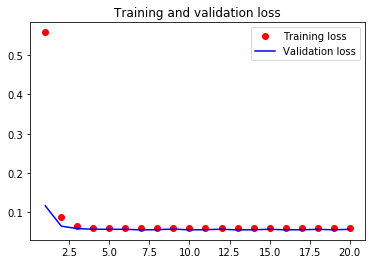

In [6]:
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### csv file (csv file name, epochs)

with open("C:/Users/richa/Desktop/Heart/Result/Invivo-I/Future_" + str(len_predic) + ".csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(['loss', 'val_loss'])
    for i in range(0,len(loss)):
        writer.writerow([loss[i],val_loss[i]])